In [1]:
import glob
import importlib
import os
import random
import sys
from itertools import combinations

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import prettypyplot as pplt
import scipy
import seaborn as sns
from matplotlib import ticker

import extq

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import plotting
import util

In [3]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)
pplt.load_cmaps()

In [4]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(
    np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy")[:115])
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy")[:115])
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")
# displacement charges
dq_trajs = list(np.load(f"{DATA_DIR}/raw_feat/displacement_q_0-178.npy"))
dq_trajs.extend(
    np.load(f"{DATA_DIR}/raw_feat/displacement_q_179-end.npy", allow_pickle=True)
)
dq_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/displacement_q_anton2.npy"))
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[
    8
]  # 50 ns lag time
# weights
weights = np.load(
    f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True
)[
    0
]  # 0.1 ns lag time

# remove trajectory 180 (missing full data)
cv_trajs = [*cv_trajs[:180], *cv_trajs[181:]]
sb_trajs = [*sb_trajs[:180], *sb_trajs[181:]]
sb_arr = np.concatenate(sb_trajs)
cv_arr = np.concatenate(cv_trajs)
qp_du = [*qp_du[:180], *qp_du[181:]]
weights = [*weights[:180], *weights[181:]]

In [5]:
print(
    cv_arr.shape,
    sb_arr.shape,
    np.concatenate(qp_du).shape,
    np.concatenate(dq_trajs).shape,
)

(4050115, 2) (4050115, 60) (4050115,) (4050115,)


# Bin $Q_{\rm d}$ values

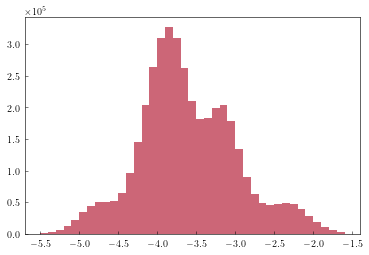

In [10]:
plt.hist(np.concatenate(dq_trajs), bins=np.arange(-5.5, -1.5, 0.1))
plt.show()

In [39]:
def compute_D(trajs, dtrajs, nbins, lag):
    displacements = np.empty(nbins, dtype=object)
    for i in range(nbins):
        displacements[i] = []
    for traj, dtraj in zip(trajs, dtrajs):
        delta = traj[lag:] - traj[:-lag]
        for i, binnum in enumerate(dtraj[:-lag]):
            displacements[binnum].append(delta[i])
    diffusions = np.zeros(nbins)
    for i, deltalist in enumerate(displacements):
        diffusions[i] = np.var(deltalist) / (2 * lag)
    return diffusions


def compute_D_2(trajs, dtrajs, nbins, lag):
    displacements = np.empty(nbins, dtype=object)
    for i in range(nbins):
        displacements[i] = []
    for traj, dtraj in zip(trajs, dtrajs):
        delta = traj[lag:] - traj[:-lag]
        for i, binnum in enumerate(dtraj[:-lag]):
            displacements[binnum].append(delta[i])
    diffusions = np.zeros(nbins)
    for i, deltalist in enumerate(displacements):
        # use the mean squared displacement
        diffusions[i] = np.mean(np.array(deltalist)**2) / (2 * lag)
    return diffusions

In [24]:
lags = [1, 5, 10, 20, 50]
bins = np.arange(-5.5, -1.5, 0.1)
dtrajs = [np.digitize(traj, bins) for traj in dq_trajs]

In [40]:
D = compute_D(dq_trajs, dtrajs, 41, 1)
D2 = compute_D_2(dq_trajs, dtrajs, 41, 1)

In [42]:
Ds = []
D2s = []
for lag in lags:
    Ds.append(compute_D(dq_trajs, dtrajs, 41, lag))
    D2s.append(compute_D_2(dq_trajs, dtrajs, 41, lag))

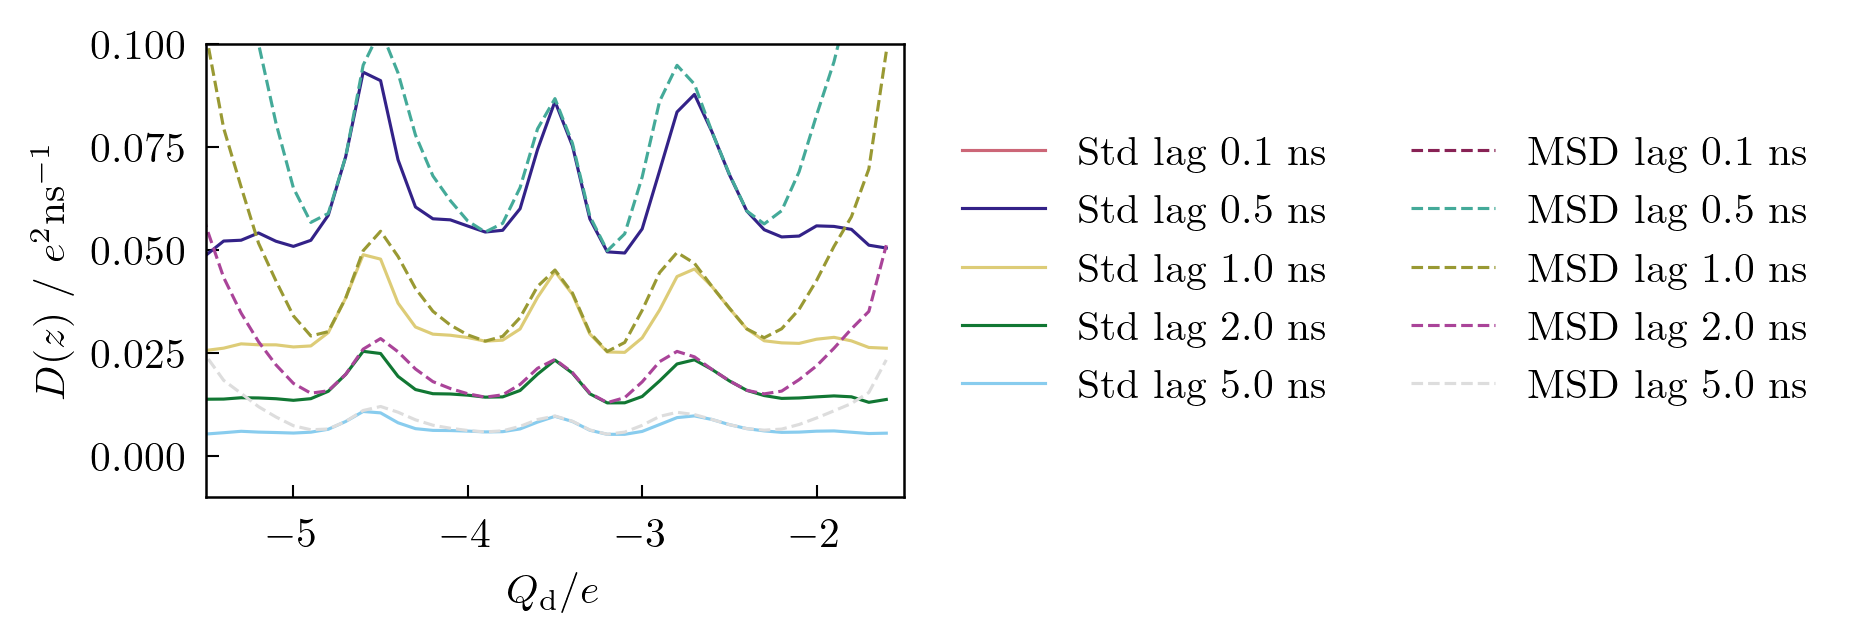

In [51]:
f = plt.figure(figsize=(3, 2), dpi=300)
for lag, D in zip(lags, Ds):
    plt.plot(np.arange(-5.6, -1.5, 0.1), D * 10, label=f"Std lag {lag * 0.1} ns")
for lag, D2 in zip(lags, D2s):
    plt.plot(np.arange(-5.6, -1.5, 0.1), D2 * 10, '--', label=f"MSD lag {lag * 0.1} ns")
plt.xlabel("$Q_{\\rm d} / e$")
plt.ylabel("$D(z)$ / $e^2 \\rm{ns}^{-1}$")
plt.xlim([-5.5, -1.5])
plt.ylim([-0.01, 0.1])
pplt.legend(outside='right', ncol=2)

In [52]:
lags = [5, 10, 20, 50, 100, 200, 500]
Ds = []
for lag in lags:
    Ds.append(compute_D(dq_trajs, dtrajs, 41, lag))

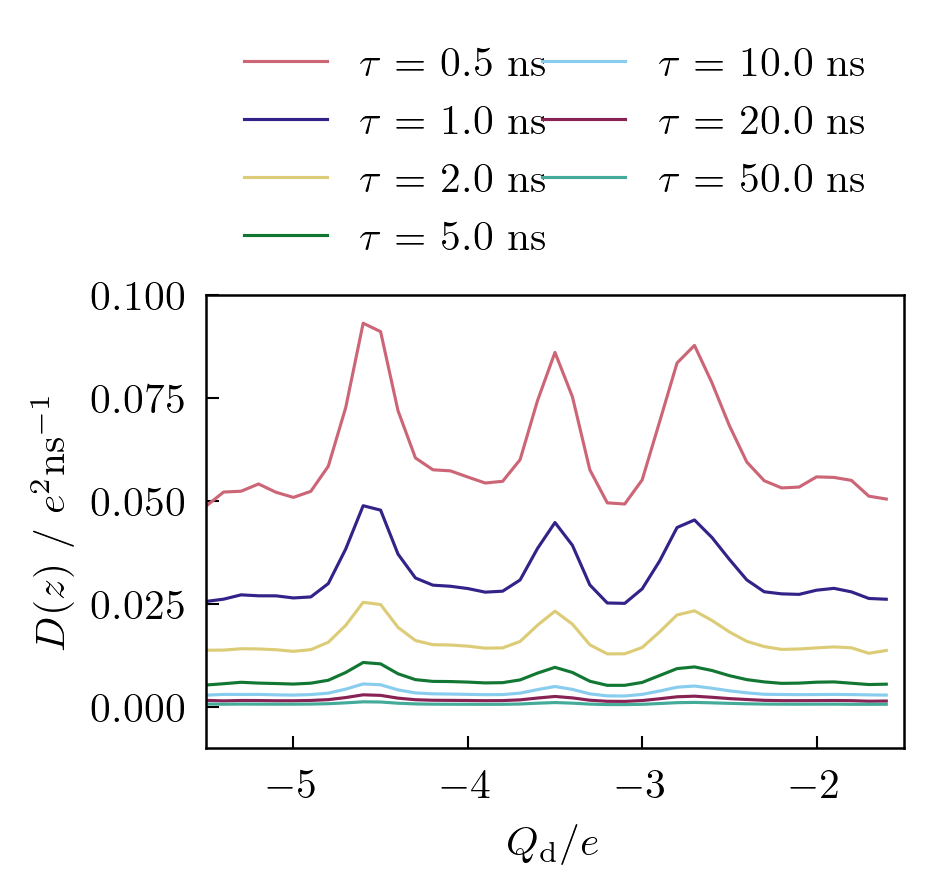

In [53]:
f = plt.figure(figsize=(3, 2), dpi=300)
for lag, D in zip(lags, Ds):
    plt.plot(np.arange(-5.6, -1.5, 0.1), D * 10, label=f"$\\tau=$ {lag * 0.1} ns")
plt.xlabel("$Q_{\\rm d} / e$")
plt.ylabel("$D(z)$ / $e^2 \\rm{ns}^{-1}$")
plt.xlim([-5.5, -1.5])
plt.ylim([-0.01, 0.1])
pplt.legend(outside='top', ncol=2)

(-5.5, -1.5)

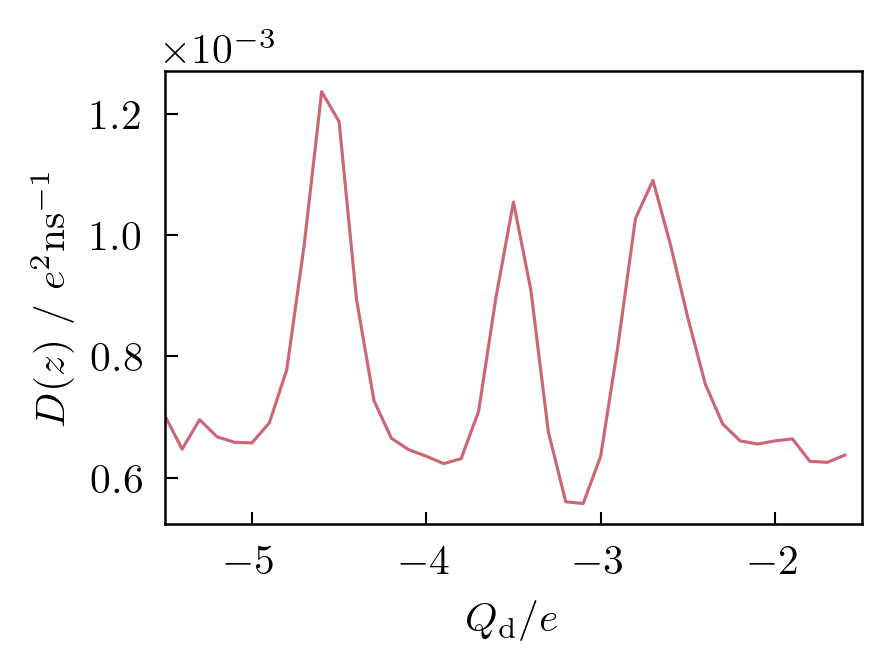

In [55]:
f = plt.figure(figsize=(3, 2), dpi=300)
plt.plot(np.arange(-5.6, -1.5, 0.1), Ds[-1] * 10, label=f"$\\tau=$ {lag * 0.1} ns")
plt.xlabel("$Q_{\\rm d} / e$")
plt.ylabel("$D(z)$ / $e^2 \\rm{ns}^{-1}$")
plt.xlim([-5.5, -1.5])
# plt.ylim([-0.01, 0.1])
# pplt.legend(outside='top', ncol=2)

# brownian dynamics